### Ulike analysemetoder er brukt i koden nedenfor

Ny kode ved bruk av funksjoner

Dropdown(description='Velg analyse:', index=3, layout=Layout(width='70%'), options=(('📊 Pearson-korrelasjon me…

Button(description='Vis graf', style=ButtonStyle())

Output()

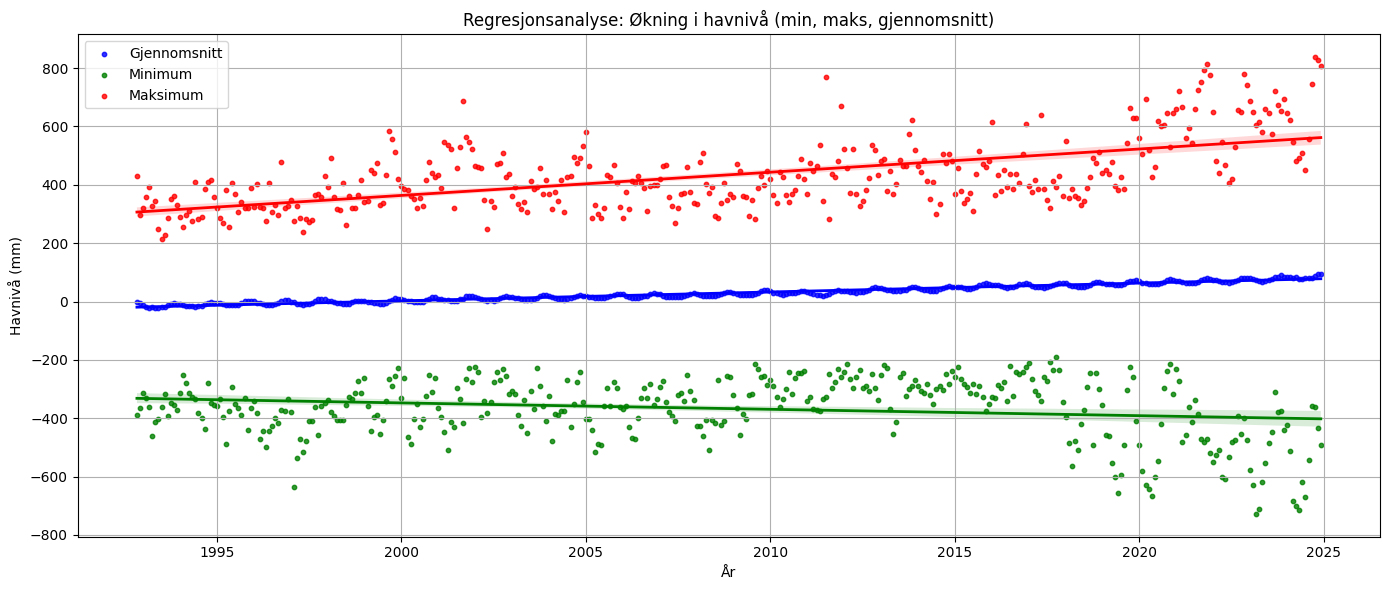

In [ ]:
import numpy as np 
import pandas as pd
import requests
from datetime import datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import ipywidgets as widgets
from IPython.display import display, clear_output

# For å bruke Plotly 
pio.renderers.default = "vscode"

# Henting av data
response = requests.get(
    "https://sealevel-nexus.jpl.nasa.gov/timeSeriesSpark",
    params={
        "ds": "NASA_SSH_REF_SIMPLE_GRID_V1_Monthly",
        "b": "-180.0,-90.0,180.0,90.0",
        "startTime": "1992-01-01T00:00:00Z",
        "endTime": "2025-01-01T00:00:00Z",
        "output": "JSON"
    }
)

# Konverter JSON til DataFrame
if response.ok and "data" in response.json():
    raw_data = [item for sublist in response.json()["data"] for item in sublist]
    df = pd.DataFrame(raw_data)
else:
    raise ValueError("Feil ved henting av data.")

# Lag en ny DataFrame med tidsstempel
df["iso_time"] = pd.to_datetime(df["iso_time"])
df["år"] = df["iso_time"].dt.year
df["måned"] = df["iso_time"].dt.to_period("M")
df["mean_mm"] = df["mean"] * 1000
df["min_mm"] = df["min"] * 1000
df["max_mm"] = df["max"] * 1000

# Rensing og utfylling av manglende punkter

# 1. Setter øvre og nedre grenser for gyldige verdier i hver måling
grenser = {
    "mean": (-1, 1),
    "min": (-1, 1),
    "max": (-1, 1)
}

# 2. Lager en maske for ugyldige verdier
ugyldig = pd.Series(False, index=df.index)
for kolonne, (min_grense, max_grense) in grenser.items():
    ugyldig |= ~df[kolonne].between(min_grense, max_grense)

antall_rensede = ugyldig.sum()

# 3. Setter ugyldige verdier til NaN
df.loc[ugyldig, ["mean_mm", "min_mm", "max_mm"]] = np.nan

# 4. Bruk interpolasjon for å fylle inn manglende verdier
df[["mean_mm", "min_mm", "max_mm"]] = df[["mean_mm", "min_mm", "max_mm"]].interpolate(method="linear")

# df er nå en komplett dataserie uten hull, og vi bruker denne videre
df_renset = df.copy()

# Lager et utgangsfelt som kan vise tekstlig output
output_tekst = widgets.Output()

# Visningsfunksjoner
def vis_korrelasjon():
    clear_output(wait=True)
    display(valg_boks, knapp, output_tekst)
    korrelasjon, _ = pearsonr(df_renset["år"], df_renset["mean_mm"])
    with output_tekst:
        output_tekst.clear_output()
        print(f"\nSammenheng mellom år og havnivåstigning (1992–2025): {korrelasjon:.3f}")
        if korrelasjon > 0.7:
            print("📈 Sterk positiv sammenheng – havnivået øker over tid.")
        elif korrelasjon < -0.7:
            print("📉 Sterk negativ sammenheng – havnivået synker over tid.")
        else:
            print("➖ Svak eller ingen klar sammenheng.")

def vis_linjediagram():
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df_renset, x="iso_time", y="mean_mm", color="blue")
    plt.title("Gjennomsnittlig økning i havnivå fra 1992 til 2025 (mm)")
    plt.xlabel("Tid")
    plt.ylabel("Havnivå (mm)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def vis_punktdiagram():
    df_mnd = df_renset[["måned", "mean_mm"]].dropna()
    df_mnd["dato"] = df_mnd["måned"].dt.to_timestamp()
    plt.figure(figsize=(12, 5))
    plt.scatter(df_mnd["dato"], df_mnd["mean_mm"], color="green", alpha=0.7, s=10)
    plt.xlabel("År")
    plt.ylabel("Havnivå (mm)")
    plt.title("Månedlig havnivåøkning fra 1992 til 2025 (punktvis)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def vis_regresjon():
    df_mnd = df_renset[["måned", "mean_mm", "min_mm", "max_mm"]].dropna()
    df_mnd["tid"] = df_mnd["måned"].dt.to_timestamp()
    df_mnd["år"] = df_mnd["tid"].dt.year + df_mnd["tid"].dt.month / 12

    plt.figure(figsize=(14, 6))
    sns.regplot(x="år", y="mean_mm", data=df_mnd, scatter=True, label="Gjennomsnitt", color="blue", scatter_kws={'s':10}, line_kws={'linewidth':2})
    sns.regplot(x="år", y="min_mm", data=df_mnd, scatter=True, label="Minimum", color="green", scatter_kws={'s':10}, line_kws={'linewidth':2})
    sns.regplot(x="år", y="max_mm", data=df_mnd, scatter=True, label="Maksimum", color="red", scatter_kws={'s':10}, line_kws={'linewidth':2})
    plt.title("Regresjonsanalyse: Økning i havnivå (min, maks, gjennomsnitt)")
    plt.xlabel("År")
    plt.ylabel("Havnivå (mm)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def vis_glidende_gjennomsnitt():
    df_renset["glidende_mean"] = df_renset["mean_mm"].rolling(window=12, min_periods=1).mean()
    plt.figure(figsize=(12, 5))
    plt.plot(df_renset["iso_time"], df_renset["mean_mm"], label="Rådata", alpha=0.3)
    plt.plot(df_renset["iso_time"], df_renset["glidende_mean"], label="12 måneders glidende gjennomsnitt", color="red")
    plt.xlabel("Tid")
    plt.ylabel("Havnivå (mm)")
    plt.title("Utvikling i havnivå fra 1992 til 2025: Glidende gjennomsnitt")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def vis_boksplott():
    plt.figure(figsize=(15, 6))
    df_renset.boxplot(column="mean_mm", by="år", grid=True, showfliers=False)
    plt.title("Årlig fordeling av havnivåøkning (1992–2025)")
    plt.suptitle("")
    plt.xlabel("År")
    plt.xticks(rotation=45)
    plt.ylabel("Havnivå (mm)")
    plt.tight_layout()
    plt.show()

def vis_interaktiv():
    df_årlig = df_renset.groupby("år")["mean_mm"].mean().reset_index()
    fig = px.line(
        df_årlig,
        x="år",
        y="mean_mm",
        title="Interaktiv visning: Gjennomsnittlig økning i havnivå (1992–2025)",
        labels={"mean_mm": "Havnivå (mm)", "år": "År"}
    )
    fig.update_layout(hovermode="x unified")
    fig.show()

# Interaktiv meny for valg av analyse
def interaktiv_meny():
    global valg_boks, knapp
    valg_boks = widgets.Dropdown(
        options=[
            ("📊 Pearson-korrelasjon mellom år og gjennomsnittlig havnivåstigning", 1),
            ("📈 Linjediagram: Gjennomsnittlig økning i havnivå over tid (Seaborn)", 2),
            ("🔹 Punktdiagram: Gjennomsnittlig utvikling i havnivå per måned", 3),
            ("📉 Regresjonsanalyse: Min, maks og gjennomsnitt", 4),
            ("📏 Glidende gjennomsnitt (12 måneder)", 5),
            ("📦 Boksplott: Fordeling per år", 6),
            ("🌍 Interaktiv graf med årlig gjennomsnitt av havnivåstigning fra 1992-2025 (Plotly)", 7),
        ],
        description="Velg analyse:",
        style={"description_width": "initial"},
        layout=widgets.Layout(width="70%")
    )

    knapp = widgets.Button(description="Vis graf")

    def vis_valg(b):
        clear_output(wait=True)
        display(valg_boks, knapp, output_tekst)
        valg = valg_boks.value
        output_tekst.clear_output()
        if valg == 1:
            vis_korrelasjon()
        elif valg == 2:
            vis_linjediagram()
        elif valg == 3:
            vis_punktdiagram()
        elif valg == 4:
            vis_regresjon()
        elif valg == 5:
            vis_glidende_gjennomsnitt()
        elif valg == 6:
            vis_boksplott()
        elif valg == 7:
            vis_interaktiv()

    knapp.on_click(vis_valg)
    display(valg_boks, knapp, output_tekst)

# Antall rensende eller manglende datapunkter som ble interpolert
print(f"🔍 Antall rensede eller manglende datapunkter som ble interpolert: {antall_rensede}")

# Start menyen
interaktiv_meny()

C:\Users\madsj\AppData\Local\Temp\ipykernel_12348\589579139.py:41: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

c:\Users\madsj\OneDrive\Dokumenter\tdt4114\TDT4114-Prosjekt\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



Modellen er trent. MSE: 34.41, R²: 0.956


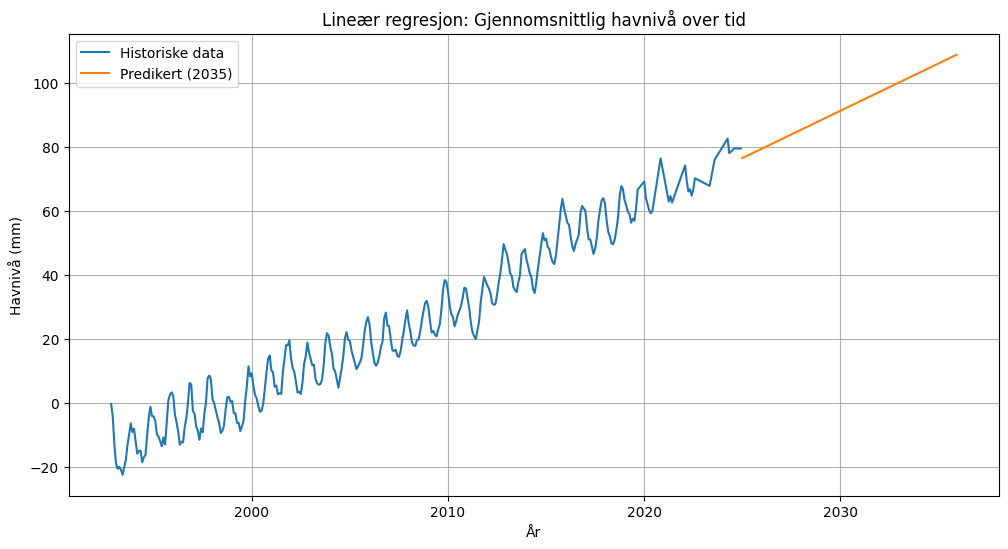

In [ ]:
import numpy as np 
import pandas as pd
import requests
from datetime import datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import ipywidgets as widgets
from IPython.display import display, clear_output

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Plotly konfig
pio.renderers.default = "vscode"

# Henting av data
response = requests.get(
    "https://sealevel-nexus.jpl.nasa.gov/timeSeriesSpark",
    params={
        "ds": "NASA_SSH_REF_SIMPLE_GRID_V1_Monthly",
        "b": "-180.0,-90.0,180.0,90.0",
        "startTime": "1992-01-01T00:00:00Z",
        "endTime": "2025-01-01T00:00:00Z",
        "output": "JSON"
    }
)

# Konverter JSON til DataFrame
if response.ok and "data" in response.json():
    raw_data = [item for sublist in response.json()["data"] for item in sublist]
    df = pd.DataFrame(raw_data)
else:
    raise ValueError("Feil ved henting av data.")

# Formater tid og enheter
df["iso_time"] = pd.to_datetime(df["iso_time"])
df["år"] = df["iso_time"].dt.year
df["måned"] = df["iso_time"].dt.to_period("M")
df["mean_mm"] = df["mean"] * 1000
df["min_mm"] = df["min"] * 1000
df["max_mm"] = df["max"] * 1000

# Rensing
grenser = {
    "mean": (-1, 1),
    "min": (-1, 1),
    "max": (-1, 0.6)
}
ugyldig = pd.Series(False, index=df.index)
for kolonne, (min_grense, max_grense) in grenser.items():
    ugyldig |= ~df[kolonne].between(min_grense, max_grense)
df.loc[ugyldig, ["mean_mm", "min_mm", "max_mm"]] = np.nan
df[["mean_mm", "min_mm", "max_mm"]] = df[["mean_mm", "min_mm", "max_mm"]].interpolate(method="linear")
df_renset = df.copy()

# Output-widget (kan brukes senere til tekstvisning)
output_tekst = widgets.Output()

# === LINEÆR REGRESJON OG PREDIKSJON ===

# Forbered data
df_renset["år_decimal"] = df_renset["iso_time"].dt.year + df_renset["iso_time"].dt.month / 12
X = df_renset[["år_decimal"]].values
y = df_renset["mean_mm"].values

# Tren modellen
modell = LinearRegression()
modell.fit(X, y)

# Evaluer
y_pred = modell.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Modellen er trent. MSE: {mse:.2f}, R²: {r2:.3f}")

# Fremtidig prediksjon til 2035
framtid = pd.DataFrame({
    "år_decimal": np.arange(2025, 2036, 1/12)
})
framtid["mean_mm_pred"] = modell.predict(framtid[["år_decimal"]])

# Visualisering
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_renset, x="år_decimal", y="mean_mm", label="Historiske data")
sns.lineplot(data=framtid, x="år_decimal", y="mean_mm_pred", label="Predikert (2035)")
plt.title("Lineær regresjon: Gjennomsnittlig havnivåstigning over tid")
plt.xlabel("År")
plt.ylabel("Havnivå (mm)")
plt.grid(True)
plt.legend()
plt.show()
